In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

np.random.seed(69)

sns.set_theme(style='whitegrid')
%matplotlib inline

In [14]:
df = pd.read_csv("wrds3.csv", low_memory = False)
#wrds1.csv has only NYSE stocks
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
df["SICCD"] = pd.to_numeric(df["SICCD"], errors="coerce").astype("Int64")
df.head()

,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,PRC,VOL,SHROUT,CFACPR,CFACSHR,NUMTRD
0,10001,2000-01-03,11,3,4920,EWST,ENERGY WEST INC,8.5625,1721.0,2450.0,1.5,1.5,2.0
1,10001,2000-01-04,11,3,4920,EWST,ENERGY WEST INC,8.4375,1080.0,2450.0,1.5,1.5,2.0
2,10001,2000-01-05,11,3,4920,EWST,ENERGY WEST INC,8.5625,1711.0,2450.0,1.5,1.5,5.0
3,10001,2000-01-06,11,3,4920,EWST,ENERGY WEST INC,8.5000,580.0,2450.0,1.5,1.5,2.0
4,10001,2000-01-07,11,3,4920,EWST,ENERGY WEST INC,8.4375,1406.0,2450.0,1.5,1.5,4.0


In [15]:
print(df['EXCHCD'].unique())
print(df['SHRCD'].unique())

[3 1]
[11 10]


In [16]:
# df.drop(["NWPERM"], axis=1, inplace=True)
df["PRC"] = df["PRC"].abs()

In [17]:
df.head()

,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,PRC,VOL,SHROUT,CFACPR,CFACSHR,NUMTRD
0,10001,2000-01-03,11,3,4920,EWST,ENERGY WEST INC,8.5625,1721.0,2450.0,1.5,1.5,2.0
1,10001,2000-01-04,11,3,4920,EWST,ENERGY WEST INC,8.4375,1080.0,2450.0,1.5,1.5,2.0
2,10001,2000-01-05,11,3,4920,EWST,ENERGY WEST INC,8.5625,1711.0,2450.0,1.5,1.5,5.0
3,10001,2000-01-06,11,3,4920,EWST,ENERGY WEST INC,8.5000,580.0,2450.0,1.5,1.5,2.0
4,10001,2000-01-07,11,3,4920,EWST,ENERGY WEST INC,8.4375,1406.0,2450.0,1.5,1.5,4.0


In [18]:
len(df["SICCD"].unique())

1135

In [19]:
tickers = [str(i) for i in df['TICKER'].unique()]
tickers.sort()
print(len(tickers))
print("LEH" in tickers)

12996
True


In [20]:
lehman_df = df[df['COMNAM'].str.contains(r'LEHMAN BRO', regex=True, case=False, na=False)]
print(lehman_df.head())

          PERMNO       date  SHRCD  EXCHCD  SICCD TICKER  \
14109084   80599 2000-01-03     11       1   6211    LEH   
14109085   80599 2000-01-04     11       1   6211    LEH   
14109086   80599 2000-01-05     11       1   6211    LEH   
14109087   80599 2000-01-06     11       1   6211    LEH   
14109088   80599 2000-01-07     11       1   6211    LEH   

                                COMNAM      PRC        VOL    SHROUT  CFACPR  \
14109084  LEHMAN BROTHERS HOLDINGS INC  79.0625   957900.0  120014.0     4.0   
14109085  LEHMAN BROTHERS HOLDINGS INC  74.3750  1771699.0  120014.0     4.0   
14109086  LEHMAN BROTHERS HOLDINGS INC  69.9375  2038799.0  120014.0     4.0   
14109087  LEHMAN BROTHERS HOLDINGS INC  72.8750  1992699.0  120014.0     4.0   
14109088  LEHMAN BROTHERS HOLDINGS INC  70.9375  1285199.0  120014.0     4.0   

          CFACSHR  NUMTRD  
14109084      4.0     NaN  
14109085      4.0     NaN  
14109086      4.0     NaN  
14109087      4.0     NaN  
14109088      4.0 

In [55]:
price_data = df[["PERMNO", "date", "TICKER", "COMNAM", "NUMTRD"]].copy()
price_data["price"] = df["PRC"] / df["CFACPR"]
price_data["market_cap"] = (df["SHROUT"] * df["CFACSHR"]) * price_data["price"] * 1000
price_data["vol"] = df["VOL"] * df["CFACSHR"]
# the number is different from the exact number but for the study we need relative numbers
price_data["sic2"] = df["SICCD"] // 100
price_data['half'] = np.where(price_data['date'].dt.month <= 6, 'H1', 'H2')
price_data['period'] = price_data['date'].dt.year.astype(str) + price_data['half']
price_data.columns = [i.lower() for i in price_data.columns]
price_data.drop(["half"], axis=1, inplace=True)
price_data = price_data.sort_values(['ticker', 'date'])
price_data = price_data[price_data['price'].notna() & (price_data['price'] > 0)]
price_data['ret'] = (
    np.log(price_data['price'] / price_data.groupby('ticker')['price'].shift(1))
)
price_data = price_data.sort_values(['date', 'ticker'])
# Remove rows where ret is NaN or infinite
price_data = price_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['ret'])

# numtrd: number of trades is useful to filter thinly traded stocks that might cloud covariance matrices
# vol: filters out tiny illiquid stocks that cannot meaningfully contribute to a portfolio

price_data.head()

/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret
10175637,69163,2000-01-03,ACV,ALBERTO CULVER CO,NaN,21.125000,4.800445e+08,6300.0,28,2000H1,0.544513
13752385,80169,2000-01-03,AGM,FEDERAL AGRICULTURAL MORT CORP,NaN,19.312500,1.800118e+08,4100.0,61,2000H1,0.188164
12368168,77881,2000-01-03,BDG,BANDAG INC,NaN,21.437500,2.311391e+08,3200.0,30,2000H1,-0.163684
7082296,29946,2000-01-03,BF,BROWN FORMAN CORP,NaN,6.146667,2.277455e+09,1075312.5,20,2000H1,0.075368
15782627,83443,2000-01-03,BRK,BERKSHIRE HATHAWAY INC DEL,NaN,35.300000,9.428630e+09,873500.0,63,2000H1,-7.347563


In [56]:
company_universe = price_data["ticker"].unique()
print(company_universe)
print(len(company_universe))

['ACV' 'AGM' 'BDG' ... 'NPKI' 'HIT' 'NEUP']
12974


In [57]:
random_ticker = random.choice(company_universe)
print(random_ticker)
random_ticker_df = price_data[price_data["ticker"] == random_ticker]
random_ticker_df.tail()

AHS


,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret
21334725,89215,2016-10-20,AHS,A M N HEALTHCARE SERVICES INC,NaN,33.74,1.621173e+09,1000282.0,87,2016H2,-0.011200
21334726,89215,2016-10-21,AHS,A M N HEALTHCARE SERVICES INC,NaN,33.35,1.602434e+09,700446.0,87,2016H2,-0.011626
21334727,89215,2016-10-24,AHS,A M N HEALTHCARE SERVICES INC,NaN,33.67,1.617810e+09,457967.0,87,2016H2,0.009549
21334728,89215,2016-10-25,AHS,A M N HEALTHCARE SERVICES INC,NaN,33.46,1.607720e+09,361838.0,87,2016H2,-0.006257
21334729,89215,2016-10-26,AHS,A M N HEALTHCARE SERVICES INC,NaN,33.02,1.586578e+09,591318.0,87,2016H2,-0.013237


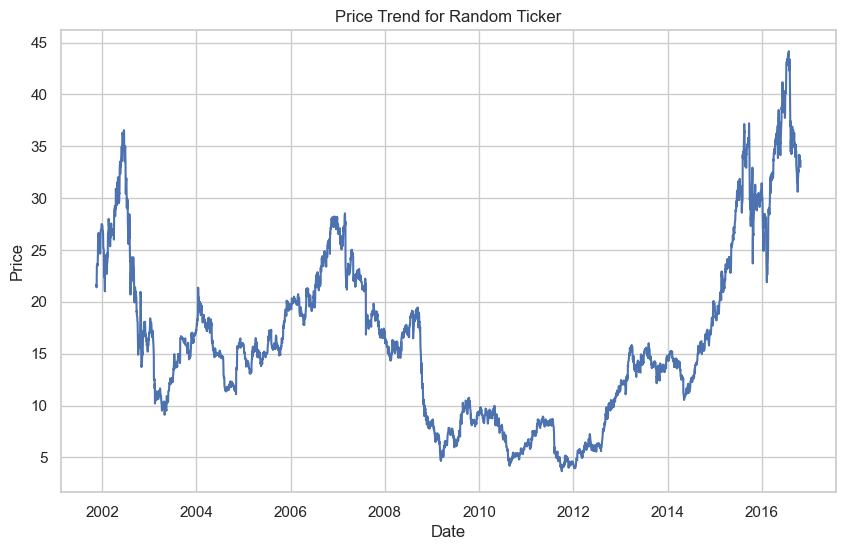

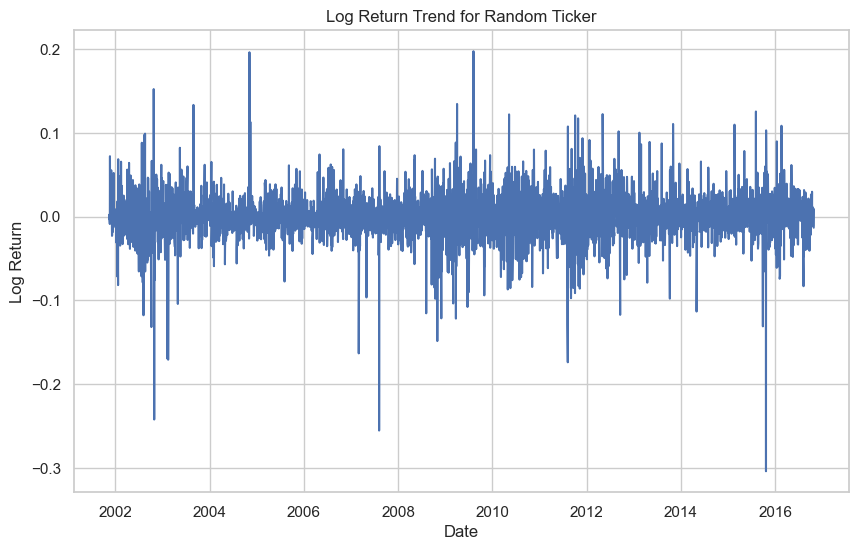

In [58]:
plt.figure(figsize=(10,6))
sns.lineplot(data=random_ticker_df, x="date", y="price")
plt.title("Price Trend for Random Ticker")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=random_ticker_df, x="date", y="ret")
plt.title("Log Return Trend for Random Ticker")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [53]:
# listing_info = pd.DataFrame()
price_data.head()

,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret
19712134,87432,2000-01-04,A,AGILENT TECHNOLOGIES INC,NaN,44.761268,1.991876e+10,3408199.0,38,2000H1,-0.093662
19712135,87432,2000-01-05,A,AGILENT TECHNOLOGIES INC,NaN,42.585076,1.895036e+10,4119199.0,38,2000H1,-0.049839
19712136,87432,2000-01-06,A,AGILENT TECHNOLOGIES INC,NaN,40.280874,1.792499e+10,1812799.0,38,2000H1,-0.055627
19712137,87432,2000-01-07,A,AGILENT TECHNOLOGIES INC,NaN,44.377234,1.974787e+10,2016899.0,38,2000H1,0.096850
19712138,87432,2000-01-10,A,AGILENT TECHNOLOGIES INC,NaN,47.065470,2.094413e+10,1536799.0,38,2000H1,0.058813


In [60]:
# First and last observation per firm
summary = price_data.groupby("permno")["date"].agg(first_obs="min", last_obs="max").reset_index()

# Define strict boundaries
start_cutoff = pd.Timestamp("2000-01-03")
end_cutoff   = pd.Timestamp("2024-12-31")

# Extract listing/delisting years only for firms strictly inside the boundaries
summary["listing_year"] = summary.loc[summary["first_obs"] > start_cutoff, "first_obs"].dt.year
summary["delisting_year"] = summary.loc[summary["last_obs"] < end_cutoff, "last_obs"].dt.year

# Count listings and delistings per year
years = range(2000, 2025)
listings = summary["listing_year"].value_counts().reindex(years, fill_value=0)
delistings = summary["delisting_year"].value_counts().reindex(years, fill_value=0)

# Combine into a single dataframe
listing_info = pd.DataFrame({"listings": listings, "delistings": delistings})
listing_info["net_change"] = listing_info["listings"] - listing_info["delistings"]
listing_info.index.name = "year"

print(f"Total listings over period: {listing_info["listings"].sum()}")
print(f"Total delistings over period: {listing_info["delistings"].sum()}")
print(f"Net listing change over period: {listing_info["net_change"].sum()}")

listing_info

Total listings over period: 11976
Total delistings over period: 8364
Net listing change over period: 3612


,listings,delistings,net_change
year,,,
2000,6597,831,5766
2001,167,800,-633
2002,151,521,-370
2003,146,438,-292
2004,261,330,-69
2005,258,331,-73
2006,269,315,-46
2007,269,385,-116
2008,145,328,-183


In [27]:
# total_days = price_data["date"].nunique()

# threshold = 0.75
# required_representation = threshold * total_days

# coverage = (
#     price_data.groupby('permno')['date']
#     .nunique()
#     .reset_index(name = "days_present")
# )
# coverage["relative_representation"] = coverage["days_present"] / total_days

# print(f"Firms with required representation: {len(coverage.query("relative_representation >= @threshold"))}")

# coverage.head()

# # not a good way to do it

In [61]:
def sector(sic):
    if 1 <= sic <= 9:
        return 'Agri/Fish/Forestry'
    elif 10 <= sic <= 14:
        return 'Mining'
    elif 15 <= sic <= 17:
        return 'Construction'
    elif 20 <= sic <= 39:
        return 'Manufacturing'
    elif 40 <= sic <= 49:
        return 'Transp/Comm/Utilities'
    elif 50 <= sic <= 51:
        return 'Wholesale Trade'
    elif 52 <= sic <= 59:
        return 'Retail Trade'
    elif 60 <= sic <= 67:
        return 'Finance/Insurance/RealEstate'
    elif 70 <= sic <= 89:
        return 'Services'
    elif 91 <= sic <= 99:
        return 'Public Admin / Other'
    else:
        return 'Unknown'

price_data['sector'] = price_data['sic2'].apply(lambda x: sector(int(x)) if pd.notnull(x) else 'Unknown')

In [62]:
avg_size  = price_data.groupby('sector')['market_cap'].mean()
total_size = price_data.groupby('sector')['market_cap'].sum()

weights = pd.DataFrame({
    'avg_firm_weight': avg_size / avg_size.sum(),
    'total_market_weight': total_size / total_size.sum()
}).sort_values('total_market_weight', ascending=False)

weights

# if we are sampling n firms at any point, we would want that to look as close to the actual market as possible
# hence weighting by "total market weight" would be a better way than by "average firm size weight"

,avg_firm_weight,total_market_weight
sector,,
Manufacturing,0.139545,0.393441
Services,0.139959,0.194412
Finance/Insurance/RealEstate,0.103495,0.160121
Transp/Comm/Utilities,0.153430,0.093764
Retail Trade,0.146395,0.069617
Public Admin / Other,0.040831,0.038014
Mining,0.112895,0.029554
Wholesale Trade,0.059014,0.015657
Construction,0.051291,0.004516


In [63]:
sector_weights = (
    price_data
    .groupby(['period', 'sector'])['market_cap']
    .sum()
    .reset_index(name='market_cap')
)

sector_weights['weight'] = sector_weights.groupby('period')['market_cap'].transform(lambda x: x / x.sum())

sector_weights = sector_weights[['period', 'sector', 'weight']]

sector_weights.head(15)

,period,sector,weight
0,2000H1,Agri/Fish/Forestry,0.000175
1,2000H1,Construction,0.001440
2,2000H1,Finance/Insurance/RealEstate,0.146419
3,2000H1,Manufacturing,0.470339
4,2000H1,Mining,0.011544
5,2000H1,Public Admin / Other,0.000005
6,2000H1,Retail Trade,0.059895
7,2000H1,Services,0.169381
8,2000H1,Transp/Comm/Utilities,0.128312
9,2000H1,Wholesale Trade,0.012490


/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


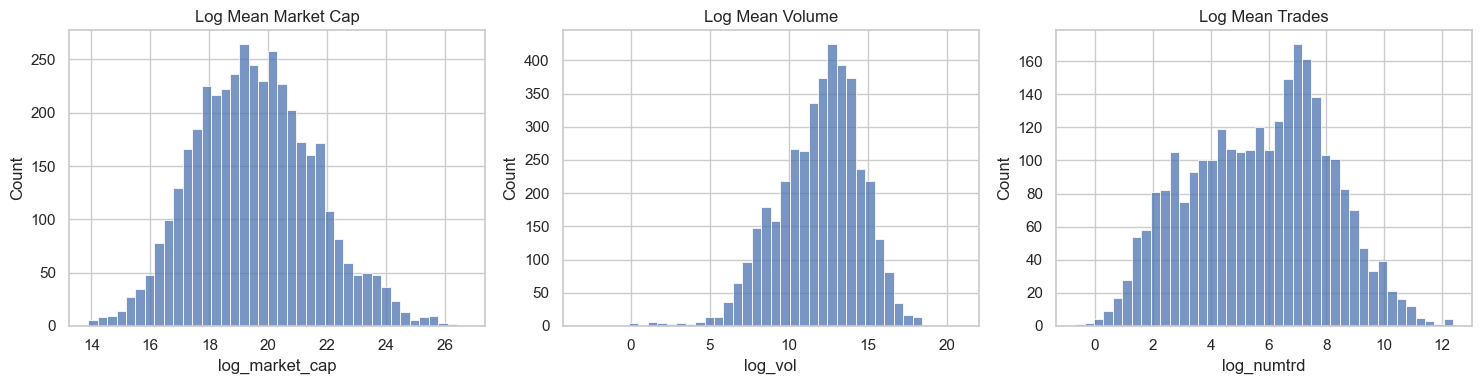

In [64]:
period = "2008H2"

period_data = price_data[price_data['period'] == period]

agg = period_data.groupby('ticker').agg({
    'market_cap': 'mean',    # mean market cap
    'vol': 'mean',           # mean volume 
    'numtrd': 'mean'         # mean number of trades
}).reset_index()

agg['log_market_cap'] = np.log(agg['market_cap'])
agg['log_vol'] = np.log(agg['vol'])
agg['log_numtrd'] = np.log(agg['numtrd'])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(agg["log_market_cap"], bins=40, ax=axes[0])
axes[0].set_title("Log Mean Market Cap")

sns.histplot(agg["log_vol"], bins=40, ax=axes[1])
axes[1].set_title("Log Mean Volume")

sns.histplot(agg["log_numtrd"], bins=40, ax=axes[2])
axes[2].set_title("Log Mean Trades")

plt.tight_layout()
plt.show()

['DCOM', 'MFSF', 'LFCO', 'TCBK', 'MBFI', 'PIOG', 'ONYX', 'UNTD', 'RIGS', 'SFFS']


Exception ignored in: <function tqdm.__del__ at 0x145bed3a0>
Traceback (most recent call last):
  File "/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


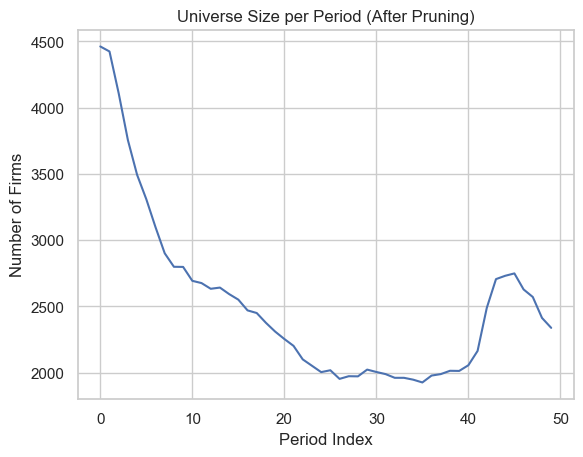

In [78]:
n_total = 250
samples_by_period = {}
universe_size_per_period = []

for period in sector_weights['period'].unique():
    period_weights = sector_weights[sector_weights['period'] == period]

    period_cutoff_data = (
        price_data[price_data['period'] == period]
        .groupby(['ticker', 'sector'])
        .agg({
            'vol': 'mean',
            'numtrd': 'mean'
        })
        .reset_index()
    )

    # period-specific cutoffs
    vol_cutoff = period_cutoff_data['vol'].quantile(0.25)
    trade_cutoff = period_cutoff_data['numtrd'].quantile(0.10)

    # apply pruning
    period_data = price_data[price_data["period"] == period]
    period_data = period_data[
        (period_data['vol'] > vol_cutoff) &
        (period_data['numtrd'] > trade_cutoff)
    ]

    universe_size_per_period.append(period_data["ticker"].nunique())

    # proportional allocation
    sector_n_raw = period_weights['weight'] * n_total
    sector_n_floor = sector_n_raw.astype(int)
    leftover = n_total - sector_n_floor.sum()
    remainders = sector_n_raw - sector_n_floor
    if leftover > 0:
        extra_idx = remainders.nlargest(leftover).index
        sector_n_floor.loc[extra_idx] += 1

    sampled_tickers = []
    for idx, row in period_weights.iterrows():
        sector = row['sector']
        n_sample = sector_n_floor.loc[idx]
        sector_firms = period_data[period_data['sector'] == sector]['ticker'].unique()
        n_sample = min(len(sector_firms), n_sample)
        if n_sample > 0:
            sampled = np.random.choice(sector_firms, size=n_sample, replace=False)
            sampled_tickers.extend(sampled)

    samples_by_period[period] = sampled_tickers
print(samples_by_period['2000H1'][:10])   # first few tickers from 2000H1
sns.lineplot(x=range(len(universe_size_per_period)), y=universe_size_per_period)
plt.title("Universe Size per Period (After Pruning)")
plt.xlabel("Period Index")
plt.ylabel("Number of Firms")
plt.show()

# Early sharp drop (2000 – 2003)	
# That’s the dot‑com collapse + “penny stock flush”. Thousands of NASDAQ issues were delisted or went illiquid. Your quantile‑based filters eliminate them, producing the plunge from ~4,500 → ~2,500.
# Gradual downward slope (2004 – 2015ish)	
# Real contraction in U.S. listings: mergers, tighter listing standards, post‑SOX delistings, and fewer IPOs. CRSP data show this decline in actual counts too.
# Small uptick around Index ≈ 40 (≈ 2020 – 2022)	
# Post‑COVID / SPAC / IPO‑boom surge. You’re capturing that wave of new small‑cap and SPAC listings with sufficient trading activity.
# Recent taper	
# Many of those 2021 listings thinned out or merged again.

In [79]:
from sklearn.covariance import LedoitWolf

corr_by_period = {}
lw = LedoitWolf()

for period, tickers in samples_by_period.items():
    dfp = price_data[(price_data['period'] == period) &
                     (price_data['ticker'].isin(tickers))]

    # aggregate to ensure uniqueness
    dfp_agg = dfp.groupby(['date', 'ticker'])['ret'].mean().reset_index()

    # pivot to wide format
    ret_wide = dfp_agg.pivot(index='date', columns='ticker', values='ret')
    ret_wide = ret_wide.fillna(0)

    X = ret_wide.values
    if X.shape[0] < 2:
        print(f"Skipping {period}, insufficient data")
        continue

    lw.fit(X)
    cov = pd.DataFrame(lw.covariance_, index=ret_wide.columns, columns=ret_wide.columns)
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr_by_period[period] = pd.DataFrame(corr, index=ret_wide.columns, columns=ret_wide.columns)

In [80]:
corr_by_period
# ensure all matrices are of the same dimension

{'2000H1': ticker      AAPL      ABIZ      ABMD      ABTE      ACCL      ACME      ACSC  \
 ticker                                                                         
 AAPL    1.000000  0.264324  0.063380 -0.056279  0.030393  0.043941  0.024753   
 ABIZ    0.264324  1.000000  0.107560  0.046885  0.098751  0.139841  0.026538   
 ABMD    0.063380  0.107560  1.000000  0.053151  0.078771  0.031603 -0.006246   
 ABTE   -0.056279  0.046885  0.053151  1.000000  0.018823  0.074025 -0.016990   
 ACCL    0.030393  0.098751  0.078771  0.018823  1.000000  0.042163  0.000350   
 ...          ...       ...       ...       ...       ...       ...       ...   
 XICO    0.172306  0.172835  0.121956  0.102113  0.017096 -0.061848  0.025696   
 XPDR    0.093131  0.126521  0.110983 -0.010197 -0.000899  0.058262  0.017652   
 XRAY    0.030605  0.045395  0.058037  0.008113  0.029253 -0.000927  0.002353   
 ZONE   -0.004598  0.201702  0.140841  0.118428 -0.026128  0.054358  0.001009   
 ZTEL    0.101722 

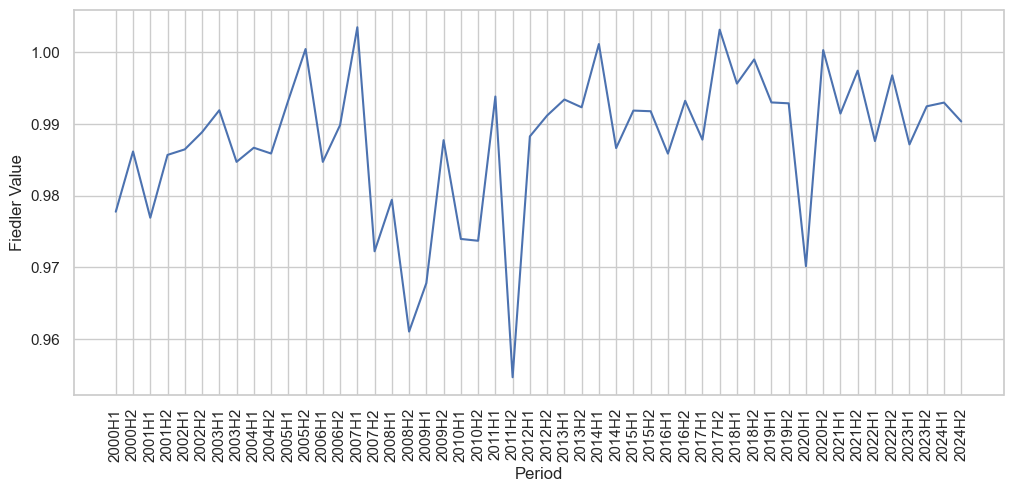

In [84]:
from scipy.sparse import csgraph

fiedler_by_period = []

for period in sorted(corr_by_period.keys()):
    corr = corr_by_period[period]
    
    if corr.shape[0] < 2:  # too few tickers
        fiedler_by_period[period] = np.nan
        continue
    
    # adjacency matrix: shift correlation [-1,1] -> [0,1]
    A = (corr.values + 1) / 2
    
    # normalized Laplacian
    L_norm = csgraph.laplacian(A, normed=True)
    
    # eigenvalues
    eigvals = np.linalg.eigvalsh(L_norm)
    
    # Fiedler value (second-smallest)
    fiedler_by_period.append(eigvals[1])

periods_sorted = sorted(samples_by_period.keys())
plt.figure(figsize=(12,5))
plt.plot(periods_sorted, fiedler_by_period, label="Fiedler Value")
plt.xticks(rotation=90)
plt.xlabel("Period")
plt.ylabel("Fiedler Value")
plt.grid(True)
plt.show()

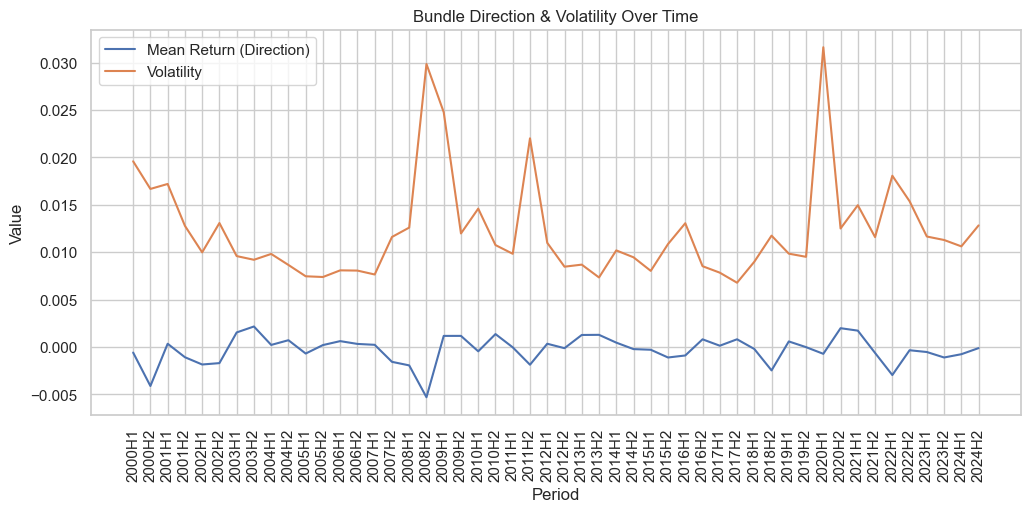

In [82]:
direction_by_period = []
volatility_by_period = []

# other ways to get directionality is a weighted average (not a fan), PC1
for period, tickers in samples_by_period.items():
    dfp = price_data[(price_data['period'] == period) &
                     (price_data['ticker'].isin(tickers))]
    
    mean_ret = dfp.groupby('date')['ret'].mean()  # average across stocks for each day
    direction_by_period.append(mean_ret.mean())  # mean over the period
    volatility_by_period.append(mean_ret.std())  # strength of moves

periods_sorted = sorted(samples_by_period.keys())
plt.figure(figsize=(12,5))
plt.plot(periods_sorted, direction_by_period, label='Mean Return (Direction)')
plt.plot(periods_sorted, volatility_by_period, label='Volatility')
plt.xticks(rotation=90)
plt.xlabel("Period")
plt.ylabel("Value")
plt.title("Bundle Direction & Volatility Over Time")
plt.legend()
plt.grid(True)
plt.show()

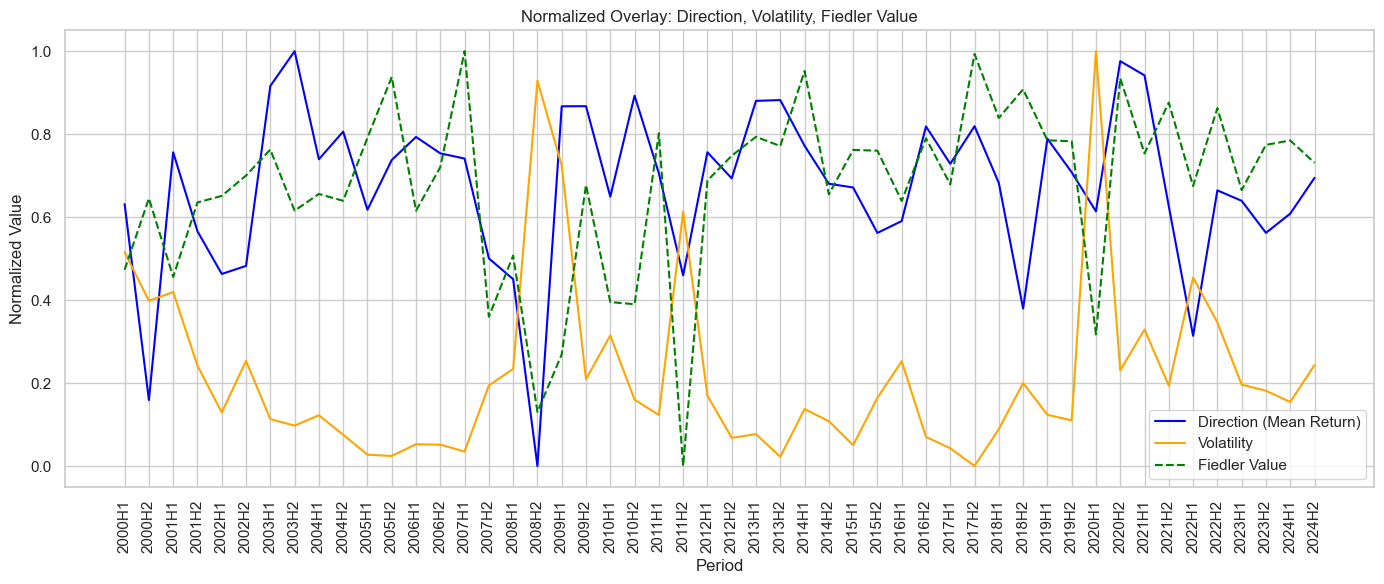

In [85]:
direction_arr = np.array(direction_by_period)
volatility_arr = np.array(volatility_by_period)
fiedler_arr = np.array(fiedler_by_period)

# min-max normalize each series to [0,1]
def normalize(arr):
    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))

direction_norm = normalize(direction_arr)
volatility_norm = normalize(volatility_arr)
fiedler_norm = normalize(fiedler_arr)

plt.figure(figsize=(14,6))
plt.plot(periods_sorted, direction_norm, label='Direction (Mean Return)', color='blue')
plt.plot(periods_sorted, volatility_norm, label='Volatility', color='orange')
plt.plot(periods_sorted, fiedler_norm, label='Fiedler Value', color='green', linestyle='--')

plt.xticks(rotation=90)
plt.xlabel('Period')
plt.ylabel('Normalized Value')
plt.title('Normalized Overlay: Direction, Volatility, Fiedler Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()